In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio

import torch as torch
import torch.nn as nn
import torch.nn.functional as F
import utils, archimedean, extreme, importlib
import importlib

import time
import pickle

%matplotlib inline

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Computer Modern Sans Serif"],
    "font.size":22})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size":22})

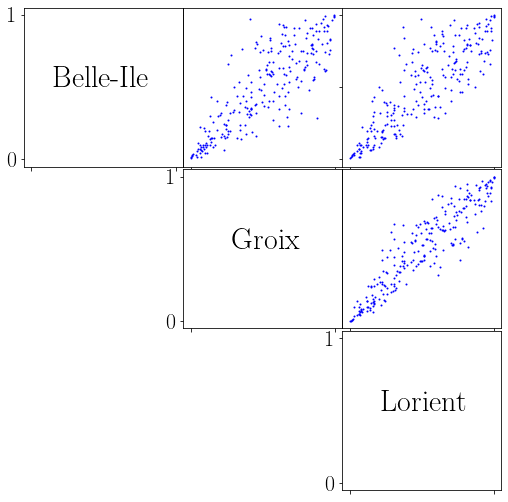

<Figure size 432x288 with 0 Axes>

In [2]:
nsamples = 240 # monthly maxima
ndims = 3

path = './data/synthetic/CNSD_C_1_14.p'
U0 = utils.load_data_0(path).float();
 
labels = ["Belle-Ile", "Groix", "Lorient"]
utils.plot_U(U0, labels=labels)

stdf = extreme.stdfNSD(alpha = torch.tensor([1.,2.,3.]), rho = torch.tensor([-0.69]))

In [3]:
# block maximas

U0_6 = U0[np.random.permutation(nsamples),:].reshape(6,-1,ndims).max(axis=0)[0].detach().numpy()
for i in range(ndims):
    U0_6[:, i] = scipy.stats.rankdata(U0_6[:, i], 'ordinal')/40
U0_6 = torch.tensor(U0_6)

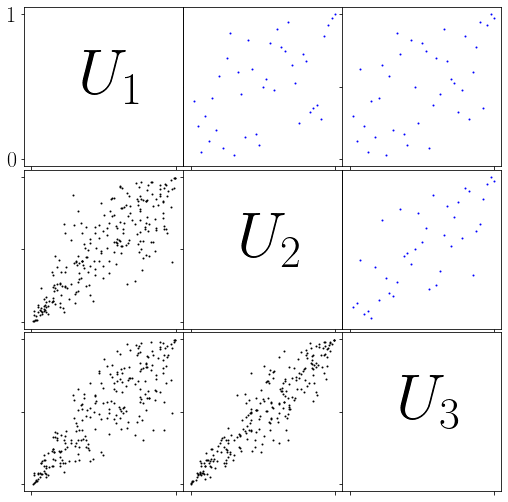

<Figure size 432x288 with 0 Axes>

In [4]:
utils.plot_U1_U2(U0_6, U0)

In [5]:
phi = archimedean.GumbelPhi(torch.tensor(1.0))

In [6]:
nan_count = 0
stdf_GNN = extreme.stdfStochastic(ndims=ndims)
opt_stdf = torch.optim.Adam(stdf_GNN.parameters(), lr=1e-3)

MSEloss = torch.nn.MSELoss()
onesd = torch.ones(stdf_GNN.ndims)/stdf_GNN.ndims

n_iter = 5100
n_z = 200
n_batch = 40
n_test = 10000
time_taken = 0

for iter_stdf in range(n_iter):
    
    U0_6 = U0[np.random.permutation(nsamples),:].reshape(6,-1,ndims).max(axis=0)[0].detach().numpy()
    for i in range(ndims):
        U0_6[:, i] = scipy.stats.rankdata(U0_6[:, i], 'ordinal')/40
    U0_6 = torch.tensor(U0_6)
    
    time_start = time.time()
    opt_stdf.zero_grad()
    stdf_GNN.resample_M(n_z)
    y = U0_6.detach()
    w = utils.rand_simplex(n_batch,ndims)
    
    x = torch.min(phi.inverse(y[:,:,None].expand(-1,-1,1))/w.T[None,:,:].expand(1,-1,-1),dim=1)[0]
    A = stdf_GNN(w)[None,:].expand(n_batch,-1)
    ll = torch.log(-phi.diff(x*A))+torch.log(A)
    lloss = -torch.mean(ll)
    scaleloss = MSEloss(stdf_GNN.M.mean(dim=0),onesd)
    regloss = lloss + scaleloss
    regloss.backward()
    opt_stdf.step()
    time_end = time.time()
    time_taken += (time_end-time_start)
    
    if iter_stdf%100 == 0:
        
        print(iter_stdf, time_taken, lloss.item(), scaleloss.item())
        
        if torch.isnan(stdf_GNN.sample(1)).sum()>1: 
            ckpt = torch.load(prev_ckpt)
            stdf_GNN.load_state_dict(ckpt['model_state_dict'])
            opt_stdf.load_state_dict(ckpt['optimizer_state_dict'])
            nan_count+= 1
            
            print("nan_count:%d"%nan_count)

            if nan_count == 3:
                break
                
        torch.save({
                'iter_stdf': iter_stdf,
                'model_state_dict': stdf_GNN.state_dict(),
                'optimizer_state_dict': opt_stdf.state_dict(),
            }, './checkpoints/ckpt_EE_1exp_i%d.ckpt'%(iter_stdf))
        
        prev_ckpt = './checkpoints/ckpt_EE_1exp_i%d.ckpt'%(iter_stdf)

/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 0.0047931671142578125 1.3306525945663452 0.005694818217307329
100 0.3139064311981201 1.314974308013916 1.0994291187671479e-05
200 0.6244018077850342 1.2849960327148438 1.0440323421789799e-05
300 0.9423210620880127 1.3075451850891113 1.815252471715212e-05
400 1.242173671722412 1.2880477905273438 0.00016251190390903503
500 1.5642180442810059 1.2237704992294312 4.877432274952298e-06
600 1.8529276847839355 1.2549673318862915 5.161266017239541e-05
700 2.155630350112915 1.3054416179656982 2.083303297695238e-05
800 2.454949140548706 1.288453221321106 2.8462202408263693e-06
900 2.7489054203033447 1.2832846641540527 5.979578781989403e-05
1000 3.0405399799346924 1.254228115081787 6.010701781633543e-06
1100 3.3632569313049316 1.2968870401382446 5.281242192722857e-05
1200 3.6622190475463867 1.211531639099121 0.00012617801257874817
1300 3.9619154930114746 1.291661024093628 7.758150786685292e-06
1400 4.273958683013916 1.2643896341323853 0.00011852168245241046
1500 4.59176778793335 1.29433774948120

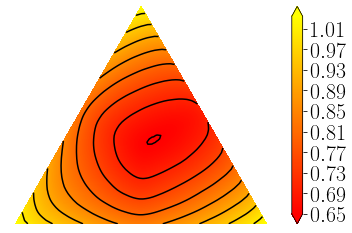

0.09769853204488754


In [7]:
Uev = stdf_GNN.sample(200000).view(100,2000,ndims).max(dim=0)[0].detach().numpy()
for i in range(ndims):
    Uev[:, i] = scipy.stats.rankdata(Uev[:, i], 'ordinal')/2000
utils.plot_stdf3(extreme.stdfCFG(torch.tensor(Uev)))

U_test = utils.rand_simplex(10000,ndims)

stdfmax = extreme.stdfCFG(torch.tensor(Uev))(U_test)
stdfGT = stdf(U_test)
IRAEloss = torch.mean(torch.abs(stdfmax-stdfGT)/stdfGT).item()
print(IRAEloss)

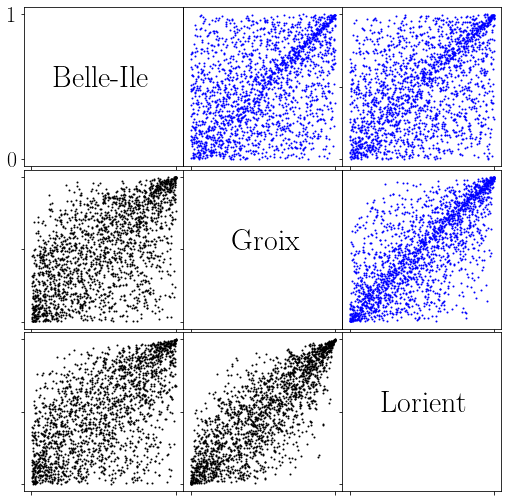

<Figure size 432x288 with 0 Axes>

In [8]:
Uev0, W = stdf.sample(2000)
utils.plot_U1_U2(torch.tensor(Uev), Uev0, labels=labels)